In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.special as poly
from math import factorial

In [2]:
dof = 4
numsteps = 25000
savesteps = 100
ft = 10.0
ic = np.array([1.0])
it = np.array([0.0])
dt = ft / savesteps

g = 1/2
coef = np.array([1., 2., -1., -0.5])

In [3]:
def mypoly(x):
    y = np.zeros((x.size, dof))
    for i in range(x.size):
        for j in range(dof):
            H = poly.hermitenorm(j, monic = True)
            # normalization constant = np.sqrt(np.sqrt(2 * np.pi) * factorial(j))
            # for probabilist's Hermite (hermitenorm)
            # normalization constant = np.sqrt(np.sqrt(np.pi) * (2**j) * factorial(j))
            # for physicists' Hermite (hermite)
            y[i,j] = H(x[i]) / np.sqrt(np.sqrt(2 * np.pi) * factorial(j))
    return y

In [4]:
def drift(x, theta):
    return (np.dot(mypoly(x), theta))

In [5]:
j = 1
x = np.zeros(savesteps + 1)
t = np.zeros(savesteps + 1)
h = ft / numsteps
h12 = np.sqrt(h)
x[0] = ic
t[0] = it

for i in range(1, numsteps + 1):
    ic = ic + drift(ic, coef) * h + g * h12 * np.random.standard_normal(1)
    if (i % (numsteps / savesteps) == 0):
        x[j] = ic
        t[j] = i*h + it
        j = j + 1

[ 1.          1.03282867  1.06989415  1.27133465  1.41876155  1.13195285
  1.42610796  1.49326222  1.88272049  2.09142152  2.30351256  2.4366033
  2.38307792  2.37697814  2.80675452  2.76562645  2.6997692   2.43727284
  2.20880072  2.25909351  2.44347341  2.66691219  2.81679409  2.7137146
  2.69374983  2.72201635  2.88997044  2.71965413  2.78937695  2.6200135
  2.73343844  2.40147303  2.30545862  2.4650136   2.33479235  2.34472571
  2.26319632  2.19174731  2.3138602   2.52340569  2.65344083  2.6415656
  2.48667553  2.57196122  2.45930668  2.42691466  2.10501214  2.17870588
  2.33383427  2.46379795  2.31530566  2.59193151  2.75661442  2.71455014
  2.813377    2.84266016  2.74284793  2.95644025  2.76142888  2.82916819
  2.82481184  2.52268699  2.65641844  2.92004794  2.80909153  2.6710511
  2.68540388  2.71289724  2.60811976  2.66389204  2.50896531  2.8536844
  2.65188271  2.66454638  2.82870427  2.55084854  2.70455957  2.52514429
  2.6797887   2.74452931  2.69504324  2.64694288  2.69706

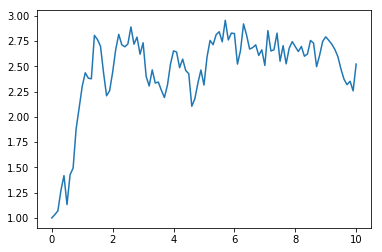

In [6]:
print(x)
print(t)
plt.plot(t, x)

In [7]:
def brownianbridge(xin, tin, n, index):
    h = (tin[index + 1] - tin[index]) / n
    tvec = tin[index] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.normal(scale=h12, size=n)
    w = np.cumsum(wincs)
    bridge = xin[index] + w - ((tvec - tin[index])/(tin[index + 1]-tin[index]))*(w[n-1] + xin[index] - xin[index + 1])
    tvec = np.concatenate((t[[index]], tvec))
    bridge = np.concatenate((x[[index]],bridge))
    return tvec, bridge

In [8]:
# girsanov LOG likelihood
def girsanov(path, dt, theta):
    b = drift(path, theta)
    int1 = np.dot(b[:-1], np.diff(path))
    b2 = np.square(b)
    int2 = np.sum(0.5*(b2[1:] + b2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

In [ ]:
theta = np.array([1.5, 1., 0., -0.25])
numsubintervals = 100
h = (t[1] - t[0])/numsubintervals
numpaths = 100
burninpaths = 100

In [ ]:
done = False
mytol = 10**(-3)
numiter = 0
while (done == False):
    numiter = numiter + 1
    print(numiter)
    mmat = np.zeros((dof, dof))
    rvec = np.zeros(dof)
    
    # for each interval of observed value (x_0 to x_n)
    for i in range(x.size-1):
        samples = np.zeros(numsubintervals)
        tout, xcur = brownianbridge(x,t,numsubintervals, i)
        oldlik = girsanov(path=xcur, dt=h, theta=theta)
        arburn = np.zeros(burninpaths)
        for jj in range(burninpaths):
            _, prop = brownianbridge(x,t,numsubintervals,i)
            proplik = girsanov(path=prop, dt=h, theta=theta)
            rho = np.exp(proplik - oldlik)
#             print("proplik:", proplik, "oldlik:", oldlik, "burnin rho", rho)
            if (rho > np.random.uniform()):
                xcur = prop
                oldlik = proplik
                arburn[jj] = 1
                
        print("Acceptance rate during burn-in:", np.mean(arburn))

        # for each path being sampled (r = 0 to r = R)
        arsamp = np.zeros(numpaths)
        for jj in range(numpaths):
            _, prop = brownianbridge(x,t,numsubintervals,i)
            proplik = girsanov(path=prop, dt=h, theta=theta)
            rho = np.exp(proplik - oldlik)
            if (rho > np.random.uniform()):
#                 print("proplik:", proplik, "oldlik:", oldlik, "sampling rho:", rho)
                xcur = prop
                oldlik = proplik
                arsamp[jj] = 1
            samples = xcur
            plt.plot(samples)
            pp = mypoly(samples[:(-1)])
            mmat = mmat + h * np.matmul(pp.T, pp) / numpaths
            rvec = rvec + np.matmul((np.diff(samples)).T, pp) / numpaths
            
        print("Acceptance rate post burn-in:", np.mean(arsamp))
#         print(mmat)
#         print(rvec)
        
    newtheta = np.linalg.solve(mmat, rvec)
    check = np.sum(np.abs(newtheta - theta))
    if (check < mytol):
        print("finished!")
        print(check)
        print(theta)
        done = True
    theta = newtheta
    print(check)
    print(theta)

1
Acceptance rate during burn-in: 0.98
Acceptance rate post burn-in: 1.0
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 0.99
Acceptance rate post burn-in: 1.0
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.98
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 1.0
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.98
Acceptance rate during burn-in: 0.99
Acceptance rate post burn-in: 1.0
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.99
Acceptance rate during burn-in: 0.99
Acceptance rate post burn-in: 0.98
Acce

In [ ]:
plt.plot(samples)

In [ ]:
x